# xFLS master catalogue
## Preparation of Legacy Survey data

The catalogue comes from `dmu0_LegacySurvey`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The aperture fluxes. Are these aperture corrected?
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

from collections import OrderedDict
import os

from astropy import units as u
from astropy import visualization as vis
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, nb_plot_mag_ap_evol, \
    nb_plot_mag_vs_apcor, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, aperture_correction, flux_to_mag

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "legacy_ra"
DEC_COL = "legacy_dec"

In [4]:
# Pritine LS catalogue
orig_legacy = Table.read("../../dmu0/dmu0_LegacySurvey/data/LegacySurvey-dr4_xFLS.fits")

## I - Aperture correction

To compute aperture correction we need to dertermine two parametres: the target aperture and the range of magnitudes for the stars that will be used to compute the correction.

**Target aperture**: To determine the target aperture, we simulate a curve of growth using the provided apertures and draw two figures:

- The evolution of the magnitudes of the objects by plotting on the same plot aperture number vs the mean magnitude.
- The mean gain (loss when negative) of magnitude is each aperture compared to the previous (except for the first of course).

As target aperture, we should use the smallest (i.e. less noisy) aperture for which most of the flux is captures.

**Magnitude range**: To know what limits in aperture to use when doing the aperture correction, we plot for each magnitude bin the correction that is computed and its RMS. We should then use the wide limits (to use more stars) where the correction is stable and with few dispersion.

In [5]:
bands = ["g", "r", "z"]
apertures      = [0,      1,   2,   3,    4,   5,   6,   7] 
aperture_sizes = [0.5, 0.75, 1.0, 1.5,  2.0, 3.5, 5.0, 7.0] #arcsec aperture sizes

flux = {}
flux_errors ={}
magnitudes = {}
flux_errors ={}
magnitude_errors = {}
stellarities = {}

flux_to_mag_vect = np.vectorize(flux_to_mag)

for band in bands:
    flux[band] = np.transpose(np.array( orig_legacy["apflux_{}".format(band)], dtype=np.float )) 
    flux_errors[band] = np.transpose(np.array( orig_legacy["apflux_ivar_{}".format(band)], dtype=np.float  ))
    
    magnitudes[band], magnitude_errors[band] = flux_to_mag_vect(flux[band] * 3.631e-6 ,flux_errors[band] * 3.631e-6)
    
    stellarities[band] = np.full(len(orig_legacy),0., dtype='float32')
    stellarities[band][np.array( orig_legacy["type"]) == "PSF" ] = 1.
    
    # Some sources have an infinite magnitude
    mask = np.isinf(magnitudes[band])
    magnitudes[band][mask] = np.nan
    magnitude_errors[band][mask] = np.nan
    

    
    
mag_corr = {}

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: invalid value encountered in double_scalars
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes


### I.a - g band

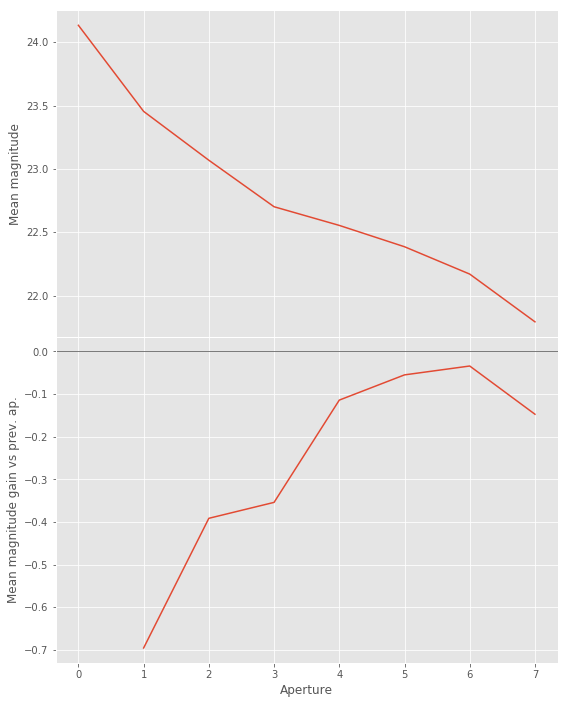

In [6]:
nb_plot_mag_ap_evol(magnitudes['g'], stellarities['g'], labels=apertures)

We will use aperture 5 as target.

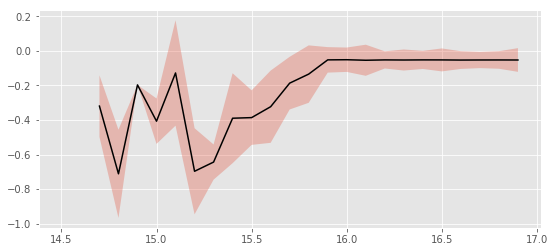

In [7]:
nb_plot_mag_vs_apcor(magnitudes['g'][4], 
                     magnitudes['g'][5], 
                     stellarities['g'])

We will use magnitudes between 17.0 and 18.5

In [8]:
# Aperture correction
mag_corr['g'], num, std = aperture_correction(
    magnitudes['g'][4], magnitudes['g'][5], 
    stellarities['g'],
    mag_min=17.0, mag_max=18.5)
print("Aperture correction for g band:")
print("Correction: {}".format(mag_corr['g']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for g band:
Correction: -0.052710849784986635
Number of source used: 4025
RMS: 0.05563683144762468


### I.b - r band

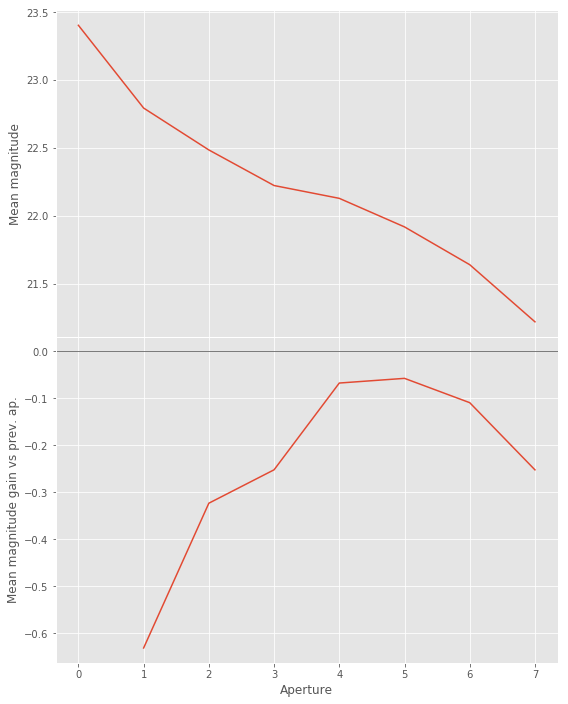

In [9]:
nb_plot_mag_ap_evol(magnitudes['r'], stellarities['r'], labels=apertures)

We will use aperture 5 as target.

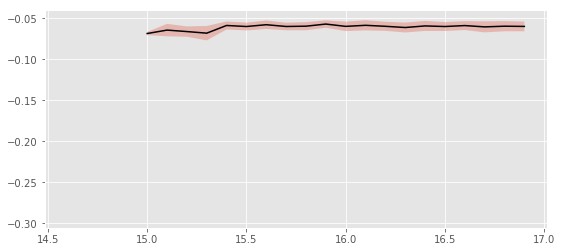

In [10]:
nb_plot_mag_vs_apcor(magnitudes['r'][4], 
                     magnitudes['r'][5], 
                     stellarities['r'])

We use magnitudes between 17.0 and 18.5.

In [11]:
# Aperture correction
mag_corr['r'], num, std = aperture_correction(
    magnitudes['r'][4], magnitudes['r'][5], 
    stellarities['r'],
    mag_min=17.0, mag_max=18.5)
print("Aperture correction for r band:")
print("Correction: {}".format(mag_corr['r']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for r band:
Correction: -0.05966928398234472
Number of source used: 1570
RMS: 0.007477466189163073


### I.c - z band

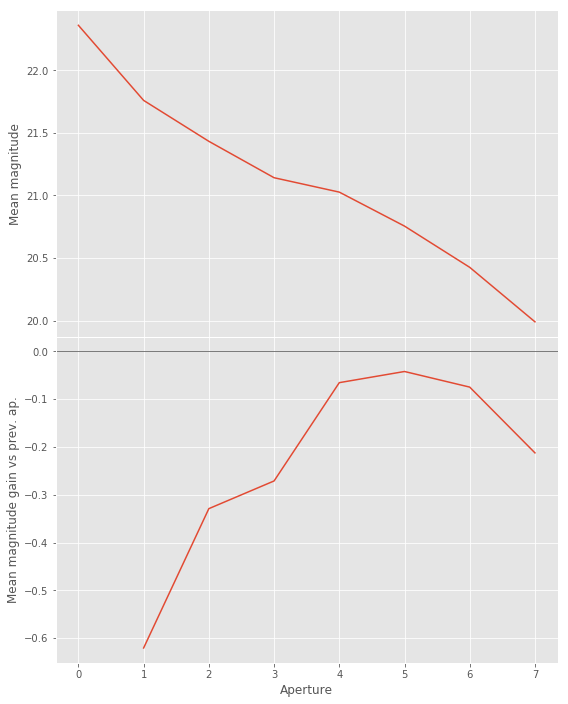

In [12]:
nb_plot_mag_ap_evol(magnitudes['z'], stellarities['z'], labels=apertures)

We will use aperture 4 as target.

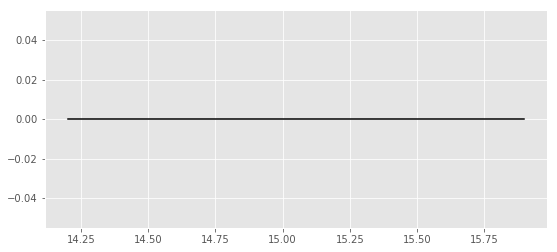

In [13]:
nb_plot_mag_vs_apcor(magnitudes['z'][4], 
                     magnitudes['z'][4], 
                     stellarities['z'])

We use magnitudes between 16.0 and 17.5.

In [14]:
# Aperture correction
mag_corr['z'], num, std = aperture_correction(
    magnitudes['z'][4], magnitudes['z'][5], 
    stellarities['z'],
    mag_min=16.0, mag_max=17.5)
print("Aperture correction for z band:")
print("Correction: {}".format(mag_corr['z']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for z band:
Correction: -0.09809793899898978
Number of source used: 3027
RMS: 0.053383225487848594


## II - Stellarity

Legacy Survey does not provide a 0 to 1 stellarity so we replace items flagged as PSF accpording to the following table:

\begin{equation*}
P(star) = \frac{ \prod_{i} P(star)_i }{ \prod_{i} P(star)_i + \prod_{i} P(galaxy)_i }
\end{equation*}

where $i$ is the band, and with using the same probabilities as UKDISS:

| HSC flag | UKIDSS flag | Meaning         | P(star) | P(galaxy) | P(noise) | P(saturated) |
|:--------:|:-----------:|:----------------|--------:|----------:|---------:|-------------:|
|          |      -9     | Saturated       |     0.0 |       0.0 |      5.0 |         95.0 |
|          |      -3     | Probable galaxy |    25.0 |      70.0 |      5.0 |          0.0 |
|          |      -2     | Probable star   |    70.0 |      25.0 |      5.0 |          0.0 |
|     0    |      -1     | Star            |    90.0 |       5.0 |      5.0 |          0.0 |
|          |      0      | Noise           |     5.0 |       5.0 |     90.0 |          0.0 |
|     1    |      +1     | Galaxy          |     5.0 |      90.0 |      5.0 |          0.0 |

In [15]:
stellarities['g'][np.isclose(stellarities['g'], 1.)] = 0.9
stellarities['g'][np.isclose(stellarities['g'], 0.)] = 0.05

In [16]:
orig_legacy.add_column(Column(data=stellarities['g'], name="stellarity")) #Stelarites computed earlier

## II - Column selection

In [17]:
imported_columns = OrderedDict({
        "objid": "legacy_id",
        "ra": "legacy_ra",
        "dec": "legacy_dec",
        "flux_g": "f_bass_g",
        "flux_ivar_g": "ferr_bass_g",
        "apflux_g": "f_ap_bass_g",
        "apflux_ivar_g": "ferr_ap_bass_g",
        "flux_r": "f_bass_r",
        "flux_ivar_r": "ferr_bass_r",
        "apflux_r": "f_ap_bass_r",
        "apflux_ivar_r": "ferr_ap_bass_r",
        "flux_z": "f_bass_z",
        "flux_ivar_z": "ferr_bass_z",
        "apflux_z": "f_ap_bass_z",
        "apflux_ivar_z": "ferr_ap_bass_z",
        "stellarity": "legacy_stellarity"
    })


catalogue = orig_legacy[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [18]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        #Convert nanomaggies to uJy
        catalogue[col] = catalogue[col] * 3.631 
        catalogue[errcol] = catalogue[errcol] * 3.631 
        catalogue[col].unit = u.microjansky
        catalogue[errcol].unit = u.microjansky
        
        #First we take aperture 4 if it is an aperture flux
        if 'ap' in col:
            catalogue[col] = catalogue[col][:, 4] 
            catalogue[errcol] = catalogue[errcol][:, 4] 
        
        mag, magerror = flux_to_mag(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        if 'ap' in col:
            mag += mag_corr[col[-1]]
            catalogue[col],catalogue[errcol] = mag_to_flux(mag,magerror)
        
        # Add magnitudes
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(magerror , name="m{}".format(errcol[1:])))
        
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: divide by zero encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: invalid value encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes


In [19]:
catalogue[:10].show_in_notebook()

idx,legacy_id,legacy_ra,legacy_dec,f_bass_g,ferr_bass_g,f_ap_bass_g,ferr_ap_bass_g,f_bass_r,ferr_bass_r,f_ap_bass_r,ferr_ap_bass_r,f_bass_z,ferr_bass_z,f_ap_bass_z,ferr_ap_bass_z,legacy_stellarity,m_bass_g,merr_bass_g,flag_bass_g,m_ap_bass_g,merr_ap_bass_g,m_bass_r,merr_bass_r,flag_bass_r,m_ap_bass_r,merr_ap_bass_r,m_bass_z,merr_bass_z,flag_bass_z,m_ap_bass_z,merr_ap_bass_z
,,deg,deg,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,,,,,,,,,,,,,,,,
0,0,256.164269113,58.6240257138,7.68693,1308.95,7.67493,2676.82,27.4722,155.643,26.9988,323.5,67.3363,51.1955,64.6861,36.4012,0.9,6.68562,184.883,False,6.68731,378.677,5.30276,6.1512,False,5.32164,13.0093,4.32938,0.82548,False,4.37297,0.610983
1,1,256.165996527,58.6221655133,0.713769,1744.39,0.571436,2676.82,3.47453,259.189,3.7786,323.499,30.5137,56.7199,29.2639,36.4011,0.9,9.26611,2653.44,False,9.50758,5085.99,7.54776,80.9924,False,7.45667,92.9536,5.18876,2.01821,False,5.23417,1.35054
2,2,256.15011622,58.6251534573,2.65886,1156.17,2.45879,2676.81,2.87843,169.992,2.69777,323.499,4.60148,115.891,4.10591,81.9502,0.05,7.83826,472.119,False,7.9232,1182.01,7.75211,64.1203,False,7.82249,130.194,7.24276,27.3448,False,7.36648,21.6703
3,3,256.152435093,58.6244304995,1.9167,819.031,1.62918,2676.82,4.12112,111.793,4.19226,323.499,13.2118,75.3215,11.6676,81.95,0.05,8.19361,463.949,False,8.37008,1783.91,7.36246,29.4525,False,7.34388,83.7816,6.0976,6.18987,False,6.23255,7.62593
4,4,256.154697104,58.6235301253,1.38352,1203.26,1.36014,2676.81,1.55905,172.98,1.74543,323.499,3.12298,115.951,3.63301,81.95,0.05,8.54754,944.28,False,8.56604,2136.77,8.41785,120.465,False,8.29524,201.231,7.66358,40.3118,False,7.49933,24.491
5,5,256.156145884,58.6228540498,1.02015,1694.9,0.810064,2676.81,3.22697,256.628,3.71833,323.498,16.6869,170.066,16.0547,81.9502,0.9,8.87834,1803.87,False,9.1287,3587.75,7.62801,86.3441,False,7.47413,94.46,5.84406,11.0654,False,5.88599,5.54206
6,6,256.147684709,58.6259175714,0.653135,1743.71,0.4994,2676.82,1.93478,262.672,1.84638,323.499,5.4419,181.52,4.36898,81.9501,0.9,9.3625,2898.65,False,9.65388,5819.63,8.18343,147.403,False,8.2342,190.228,7.06063,36.2158,False,7.29905,20.3654
7,7,256.215742257,58.6243711844,594.285,72.7946,590.788,2676.82,992.909,11.4348,988.578,323.499,1260.73,13.5936,1243.66,36.4012,0.9,1.96502,0.132993,False,1.97142,4.9194,1.40773,0.0125038,False,1.41247,0.355293,1.14845,0.0117068,False,1.16325,0.0317789
8,8,256.210277248,58.6237197146,8.58177,406.142,5.51688,2676.82,46.9608,44.3131,29.0071,323.499,124.583,14.0719,75.4941,36.4012,0.05,6.56606,51.3837,False,7.04577,526.805,4.72066,1.02452,False,5.24374,12.1086,3.66135,0.122636,False,4.20522,0.523512


## III - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [20]:
SORT_COLS = [
        'merr_ap_bass_g', 'merr_ap_bass_r', 'merr_ap_bass_z']
FLAG_NAME = 'legacy_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 183157 sources.
The cleaned catalogue has 179896 sources (3261 removed).
The cleaned catalogue has 3214 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [21]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_xFLS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

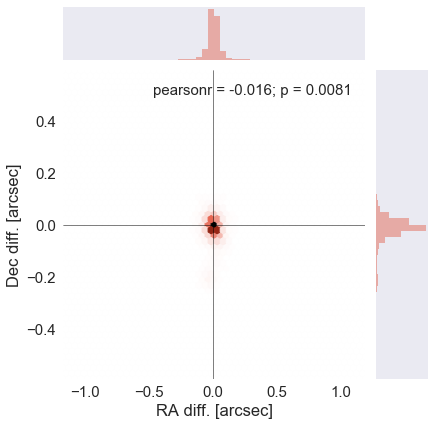

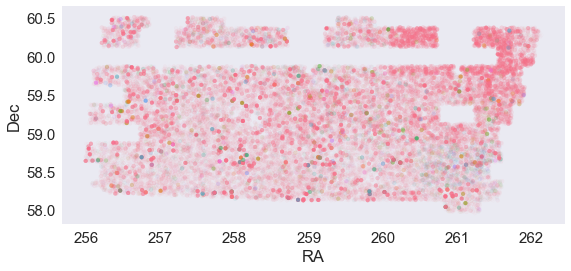

In [22]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [23]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.007263095903908834 arcsec
Dec correction: 0.0062370249253262955 arcsec


In [24]:
catalogue[RA_COL].unit = u.deg
catalogue[DEC_COL].unit = u.deg
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] +  delta_dec.to(u.deg)

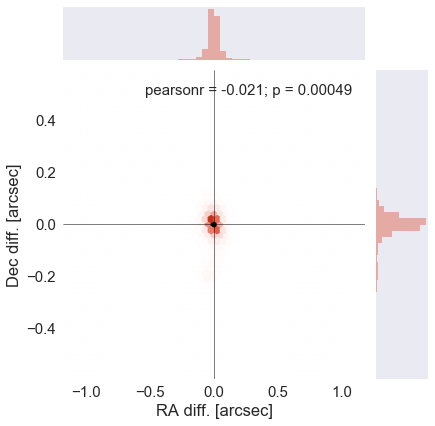

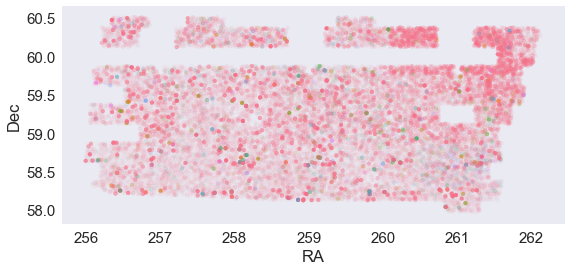

In [25]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [26]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [27]:
GAIA_FLAG_NAME = "legacy_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

29450 sources flagged.


# V - Saving to disk

In [28]:
catalogue.write("{}/LegacySurvey.fits".format(OUT_DIR), overwrite=True)